In [94]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
import copy
from collections import defaultdict

from blackjack import BlackjackEnv
import itertools
import plotting

matplotlib.style.use('ggplot')

In [95]:
env = BlackjackEnv()

In [96]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):

        # In this function, policy_fn calculates the probabilities for each action. 
        # For each action, there is an epsilon / nA chance of being selected, ensuring 
        # some level of exploration. The best action (the action with the highest Q-value 
        # for the current observation) also has an extra (1 - epsilon + epsilon / nA) chance of being 
        # selected, promoting exploitation of known good actions.

        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
        
    return policy_fn

In [97]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon_schedule=lambda i: 0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon_schedule(0), env.action_space.n)
    eucildian_distances = []
    
    for i_episode in range(1, num_episodes + 1):
        previous_policy = policy
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        epsilon = epsilon_schedule(i_episode)
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        episode = []
        state = env.reset()
        for t in range(100):  # assuming a max of 100 timesteps in an episode
            probs = policy(state)
            # An action is selected according to the probability distribution
            action = np.random.choice(np.arange(len(probs)), p=probs) 
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Update Q-values
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
            # The policy is improved implicitly by changing the Q dictionary
        
        distance = np.linalg.norm(previous_policy(state) - policy(state))
        eucildian_distances.append(distance)

    return Q, policy, eucildian_distances

In [98]:
num_episodes = 100000

fixed_schedule = lambda i: 0.5
linear_schedule = lambda i: max(0.1, 1 - i/num_episodes)
inverse_linear_schedule = lambda i: 1/(i+1)
exponential_schedule = lambda i: 0.1**(i/num_episodes)
logarithmic_schedule = lambda i: min(1, 1/(np.log(i + 2)))

In [99]:
start = time.process_time()

Q, policy, eucildian_distances = mc_control_epsilon_greedy(env, num_episodes = num_episodes, epsilon_schedule = fixed_schedule)

end = time.process_time()
print("\n",end - start,"s")


Episode 100000/100000.
 47.53125 s


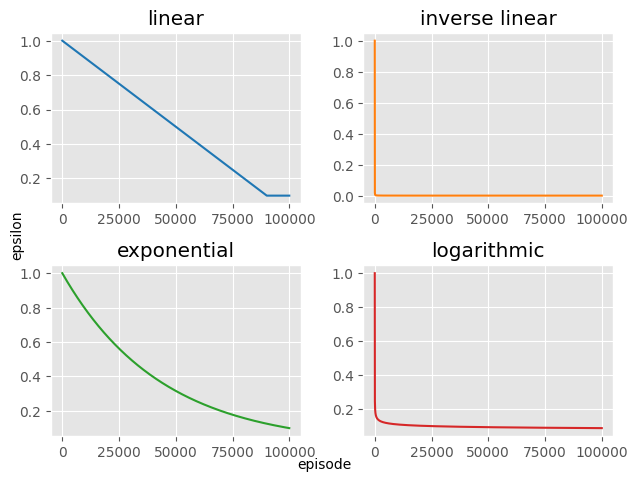

In [100]:
values = [[],[],[],[]]
for i in range(num_episodes):
    values[0].append(linear_schedule(i))
    values[1].append(inverse_linear_schedule(i))
    values[2].append(exponential_schedule(i))
    values[3].append(logarithmic_schedule(i))
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(values[0], 'tab:blue')
axs[0, 0].set_title('linear')
axs[0, 1].plot(values[1], 'tab:orange')
axs[0, 1].set_title('inverse linear')
#axs[0,1].set_yscale('log')
axs[1, 0].plot(values[2], 'tab:green')
axs[1, 0].set_title('exponential')
axs[1, 1].plot(values[3], 'tab:red')
axs[1, 1].set_title('logarithmic')
#axs[1,1].set_yscale('log')

fig.text(0.5, 0.02, 'episode', ha='center', va='center') #xlabel
fig.text(0.02, 0.5, 'epsilon', ha='center', va='center', rotation='vertical') #ylabel
fig.tight_layout()
plt.savefig('schedules')

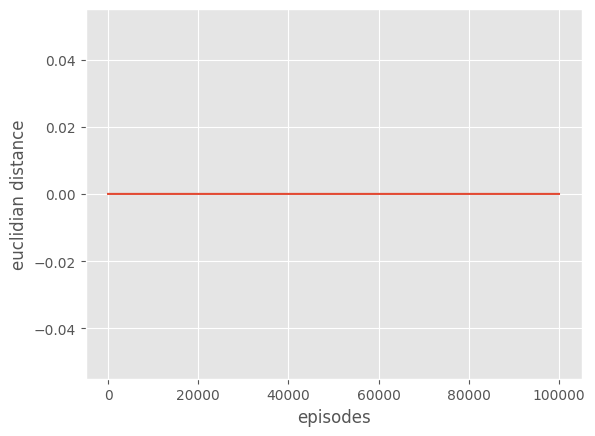

In [105]:
plt.plot(eucildian_distances[1:-1])
plt.xlabel("episodes")
plt.ylabel("euclidian distance")
#plt.title("Policy Convergence")
#axs.set_yscale('log')
#plt.savefig('logarithmic.png')
#plt.savefig('linear.png')
plt.savefig('constant.png')
plt.show()

C:\Users\Filip\AppData\Local\Temp\ipykernel_12444\1802220070.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs.set_yscale('log')


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


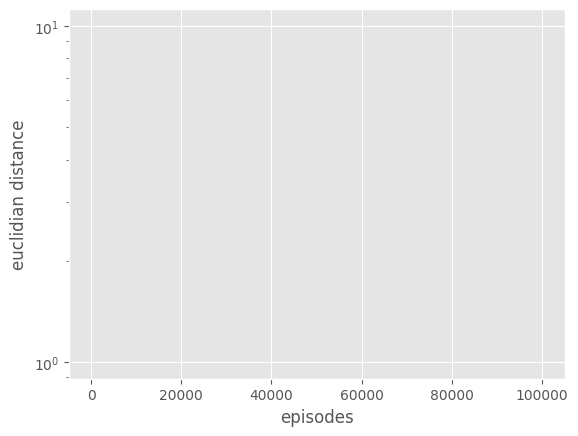

In [102]:

fig, axs = plt.subplots()
axs.plot(eucildian_distances[1:-1])
axs.set_xlabel('episodes')
axs.set_ylabel('euclidian distance')
#axs.title("Policy Convergence")
axs.set_yscale('log')
#plt.savefig('inverse_linear_ls.png')
#plt.savefig('exponential_ls.png')
#plt.savefig('logarithmic_ls.png')
#axs.show()
print(eucildian_distances[1:100])

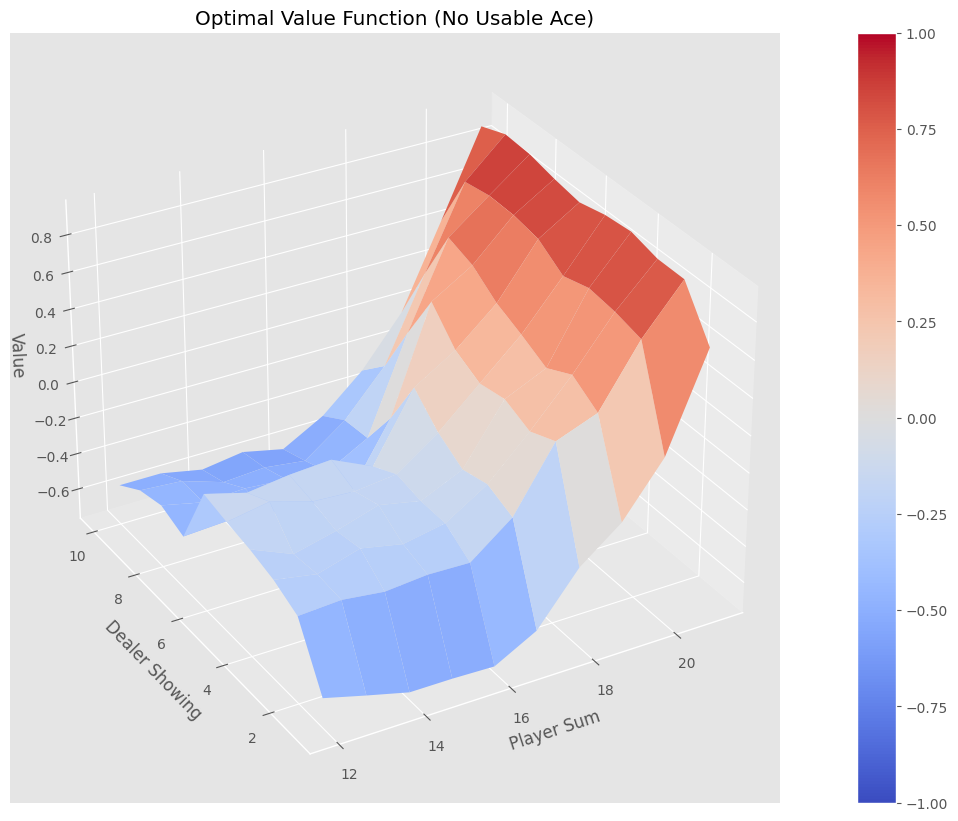

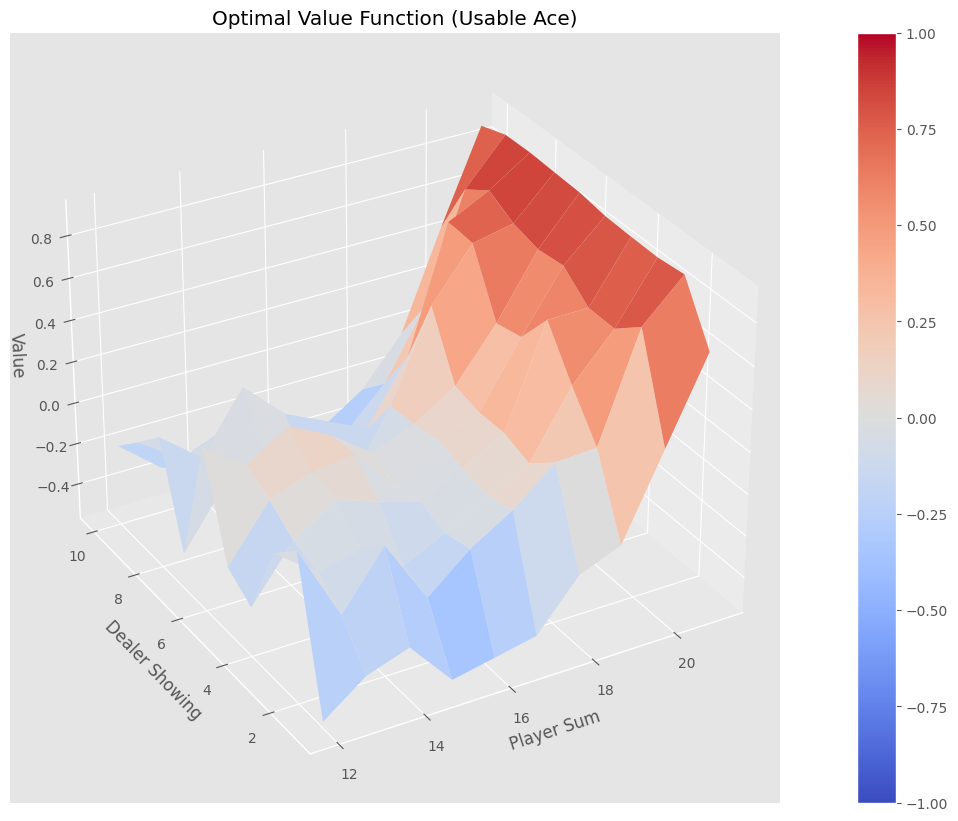

In [103]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

Evaluation 100/100.
Standard error 0.0029833930153434366
Mean: -0.20399657109967353
Variance: 0.8908527161640787


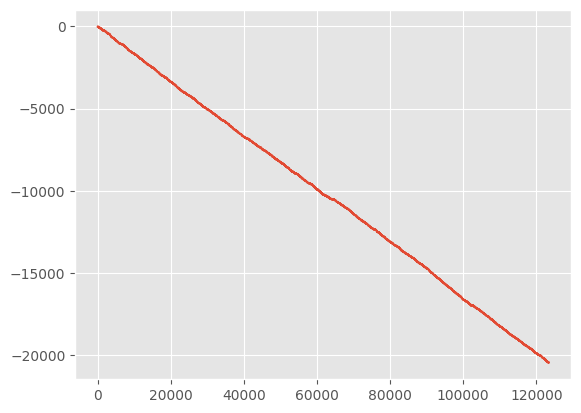

In [104]:
#evaluation
reward_episode = []
reward_step = []
num_eval = 100
episode_rewards = 0
step_rewards =0
mean_eval = []
variance_eval = []
std_eval = []
for i_eval in range(1, num_eval+1):
    print("\rEvaluation {}/{}.".format(i_eval, num_eval), end="")
    sys.stdout.flush()
    for i_episode in range(1000):
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        state = env.reset()
        for t in range(100):  # assuming a max of 100 timesteps in an episode
            probs = policy(state)
            # An action is selected according to the probability distribution
            action = np.random.choice(np.arange(len(probs)), p=probs) 
            next_state, reward, done, _ = env.step(action)
            step_rewards += reward
            reward_step.append(step_rewards)
            #episode.append((state, action, reward))
            if done:
                episode_rewards += reward
                reward_episode.append(reward)
                break
            state = next_state
    mean = np.mean(reward_episode)
    mean_eval.append(mean)
    variance = np.var(reward_episode)
    variance_eval.append(variance)
    std = np.std(reward_episode)/np.sqrt(1000)
    std_eval.append(std)

#standard error = std/sqrt(nbr of iterations)
print("\nStandard error", np.mean(std)/np.sqrt(num_eval) )
print("Mean:", np.mean(mean_eval))
print("Variance:", np.mean(variance_eval))


plt.plot(reward_step)
plt.show()